In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost statsmodels tensorflow


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/kaggle/input/energy-ml/household_power_consumption.txt", 
                 sep=";", 
                 na_values="?",  # Convert '?' to NaN
                 low_memory=False)

# Combine 'Date' and 'Time' into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop old Date and Time columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Convert numeric columns to float
for col in df.columns:
    if col != "DateTime":
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Set DateTime as index
df.set_index("DateTime", inplace=True)

# Check the dataset
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
import pandas as pd
import numpy as np

# Define the correct file path
file_path = "/kaggle/input/energy-ml/household_power_consumption.txt"

# Read the dataset with proper parsing and handling missing values
df = pd.read_csv(file_path, sep=";", 
                 parse_dates={'Datetime': ['Date', 'Time']},  # Combine Date and Time columns
                 date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M:%S'), 
                 na_values=['?'],  # Handle missing values
                 low_memory=False)  # Prevent memory errors

# Convert numerical columns to float (handling missing values)
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Resample to hourly mean values
df.set_index('Datetime', inplace=True)  
df = df.resample('h').mean()  # Use lowercase 'h' for hours

# Display the first few rows
print(df.head())


<ipython-input-4-e25317442add>:8: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path, sep=";",
<ipython-input-4-e25317442add>:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_path, sep=";",


                     Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000   
2006-12-

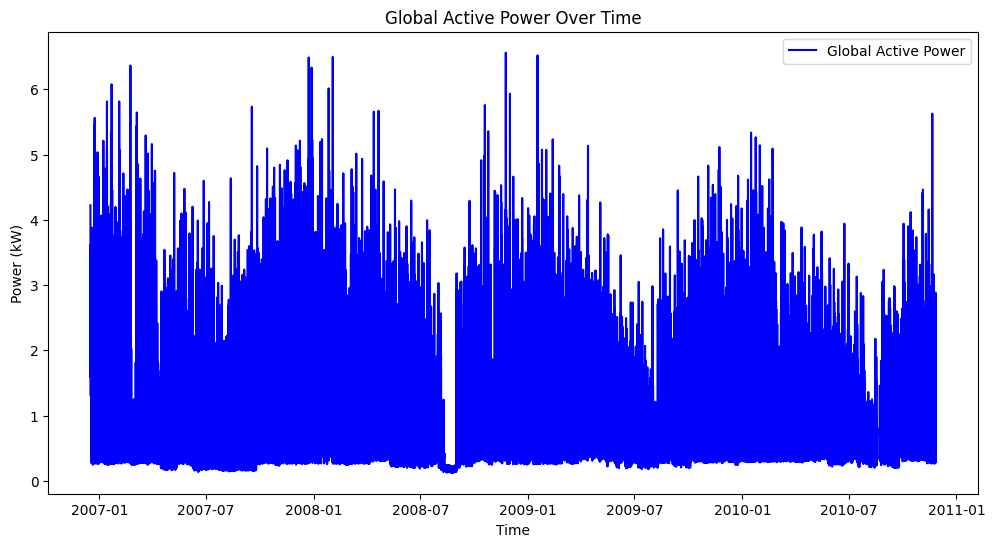

In [5]:
# Visualization: Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power', color='b')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('Global Active Power Over Time')
plt.legend()
plt.show()

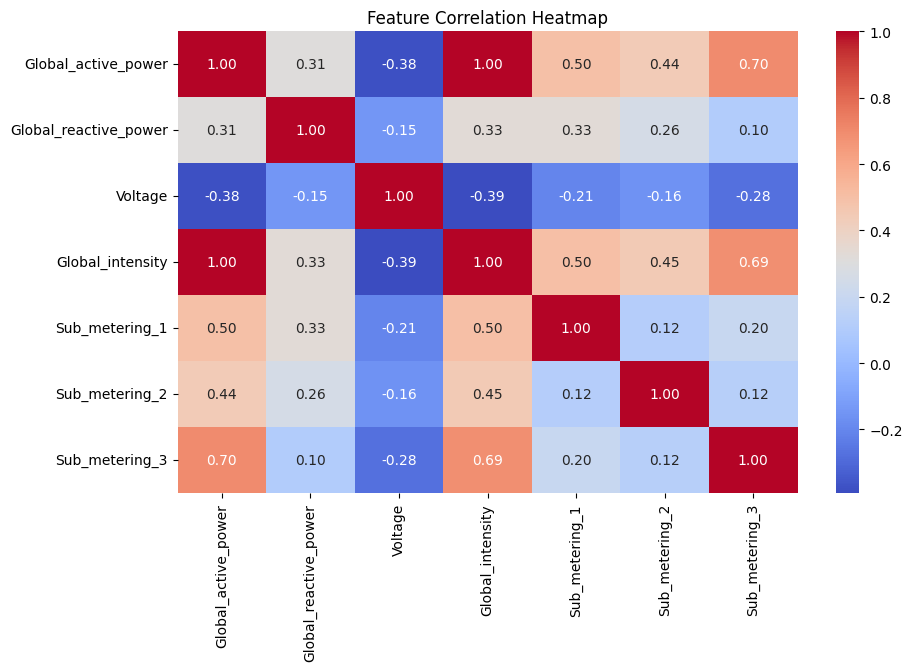

In [6]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [7]:
# Feature Engineering: Extract Time-Based Features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday

In [8]:
# Rolling Averages
df['rolling_mean'] = df['Global_active_power'].rolling(window=24).mean()

# Prepare data for modeling
X = df[['hour', 'day', 'month', 'weekday', 'Voltage', 'Global_intensity']]
y = df['Global_active_power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.impute import SimpleImputer

# Separate features (X) and target (y)
X = df.drop(columns=['Global_active_power'])  # Features
y = df['Global_active_power']  # Target variable

# Handle missing values in y (Target Variable)
y_imputer = SimpleImputer(strategy='mean')  # Replace NaN with mean
y = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()  # Flatten to 1D array

# Handle missing values in X (Features)
X_imputer = SimpleImputer(strategy='mean')  # Replace NaN with mean
X = X_imputer.fit_transform(X)  # Apply imputation

# Convert back to DataFrame for easier analysis (Optional)
import pandas as pd
X = pd.DataFrame(X, columns=df.drop(columns=['Global_active_power']).columns)

print("✅ Missing values handled successfully!")


✅ Missing values handled successfully!


In [10]:
# Check if there are any NaN values left in X and y
print("Missing values in X (features):\n", pd.DataFrame(X).isnull().sum())
print("\nMissing values in y (target):", pd.Series(y).isnull().sum())


Missing values in X (features):
 Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
hour                     0
day                      0
month                    0
weekday                  0
rolling_mean             0
dtype: int64

Missing values in y (target): 0


In [11]:
print(type(df))  # Check if df is None


<class 'pandas.core.frame.DataFrame'>


In [12]:
import pandas as pd
df = pd.read_csv("/kaggle/input/power-house-energy-1/powerconsumption.csv")  # Replace with actual file path
df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [13]:
print(df.columns)  # Check if 'PowerConsumption_Zone1' exists


Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
      dtype='object')


In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset (ensure you replace 'your_file.csv' with the actual file path)
df = pd.read_csv("/kaggle/input/power-house-energy-1/powerconsumption.csv", parse_dates=["Datetime"])  # Ensure Datetime is in datetime format

# Define Features (X) and Target (y)
X = df[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']]  # Features
y = df['PowerConsumption_Zone1']  # Target variable (Change to Zone2 or Zone3 if needed)

# Split into Train and Test Sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of train and test sets
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 41932, Testing samples: 10484


In [15]:
# Save train and test datasets as CSV files
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Train and test datasets saved successfully!")


Train and test datasets saved successfully!


In [16]:
import pandas as pd  

# Save train and test datasets as CSV files
X_train.to_csv("/kaggle/working/X_train.csv", index=False)
X_test.to_csv("/kaggle/working/X_test.csv", index=False)
y_train.to_csv("/kaggle/working/y_train.csv", index=False)
y_test.to_csv("/kaggle/working/y_test.csv", index=False)

print("Train and test datasets saved successfully!")


Train and test datasets saved successfully!


In [17]:
import pandas as pd  
import numpy as np  

# Load train data
X_train = pd.read_csv("/kaggle/working/X_train.csv")
y_train = pd.read_csv("/kaggle/working/y_train.csv")

# Load test data
X_test = pd.read_csv("/kaggle/working/X_test.csv")
y_test = pd.read_csv("/kaggle/working/y_test.csv")

# Check first few rows
print(X_train.head())
print(y_train.head())

# Check for missing values
print(X_train.isnull().sum())


   Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  DiffuseFlows
0        30.17     52.03      4.926              432.100       110.400
1        19.37     90.60      0.307                0.073         0.130
2        29.97     33.98      4.916               70.700        72.500
3        12.34     85.30      0.076                0.055         0.163
4        18.10     62.42      0.089               73.800        83.300
   PowerConsumption_Zone1
0             35567.84053
1             24352.56637
2             41857.27575
3             23272.85106
4             35775.18987
Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
dtype: int64


In [18]:
from sklearn.preprocessing import StandardScaler  

# Fill missing values
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
from sklearn.linear_model import LinearRegression  
from sklearn.ensemble import RandomForestRegressor  
from xgboost import XGBRegressor  
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Performance:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  R² Score: {r2}")
    print("-" * 40)


Linear Regression Performance:
  MAE: 5185.735681819879
  MSE: 39842406.21828706
  R² Score: 0.2109537504191329
----------------------------------------


<ipython-input-19-1bfcda63d9ec>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled, y_train)


Random Forest Performance:
  MAE: 3211.1884930622473
  MSE: 21488349.57611612
  R² Score: 0.5744408219266934
----------------------------------------
XGBoost Performance:
  MAE: 3956.408796239985
  MSE: 27557640.68018266
  R² Score: 0.45424347849716495
----------------------------------------


In [20]:
from sklearn.model_selection import RandomizedSearchCV  

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = RandomizedSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 30}


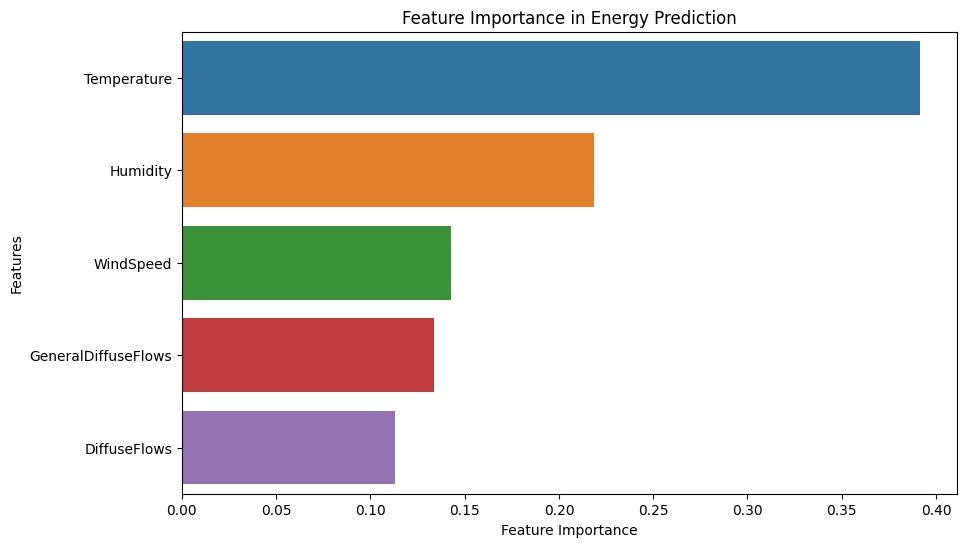

In [21]:
import matplotlib.pyplot as plt  
import seaborn as sns  

# Feature importance from Random Forest
best_model = models["Random Forest"]
importances = best_model.feature_importances_
feature_names = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Energy Prediction")
plt.show()


In [22]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)

# Train models
rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)


<ipython-input-22-bfd9407ad1c9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
import pickle

with open("linear_regression_model.pkl", "wb") as file:
    pickle.dump(model, file)  # Ensure 'model' is properly trained


In [24]:
with open("linear_regression_model.pkl", "rb") as file:
    model = pickle.load(file)


In [25]:
with open("linear_regression_model.pkl", "rb") as file:
    content = file.read()
print(content[:50])  # Check first few bytes


b'\x80\x04\x95&\x03\x00\x00\x00\x00\x00\x00\x8c\x0fxgboost.sklearn\x94\x8c\x0cXGBRegressor\x94\x93\x94)\x81\x94}'


In [26]:
import pickle

with open("/kaggle/working/random_forest_model.pkl", "wb") as file:
    pickle.dump(model, file)  # Ensure 'model' is properly trained


In [27]:
with open("/kaggle/working/random_forest_model.pkl", "rb") as file:
    content = file.read()
print(content[:50])  # Check first few bytes

b'\x80\x04\x95&\x03\x00\x00\x00\x00\x00\x00\x8c\x0fxgboost.sklearn\x94\x8c\x0cXGBRegressor\x94\x93\x94)\x81\x94}'


In [28]:
import pickle

with open("/kaggle/working/xgboost_model.pkl", "wb") as file:
    pickle.dump(model, file)  # Ensure 'model' is properly trained


In [29]:
with open("/kaggle/working/xgboost_model.pkl", "rb") as file:
    content = file.read()
print(content[:50])  # Check first few bytes

b'\x80\x04\x95&\x03\x00\x00\x00\x00\x00\x00\x8c\x0fxgboost.sklearn\x94\x8c\x0cXGBRegressor\x94\x93\x94)\x81\x94}'


In [30]:
import sys
import xgboost
print(sys.version)
print(xgboost.__version__)


3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.0.3


In [31]:
import joblib

# Load using joblib
model = joblib.load("/kaggle/working/xgboost_model.pkl")


In [32]:
import os

file_path = "xgboost_model.pkl"
if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    print("File exists and is not empty.")
else:
    print("File is missing or empty.")


File exists and is not empty.


In [33]:
import xgboost as xgb
import joblib

# Assuming 'model' is your trained XGBRegressor
joblib.dump(model, "xgboost_model.pkl")


['xgboost_model.pkl']

In [34]:
model = joblib.load("xgboost_model.pkl")


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
# Load the test data
X_test = pd.read_csv("/kaggle/working/X_test.csv")
y_test = pd.read_csv("/kaggle/working/y_test.csv")
rf_model = joblib.load("/kaggle/working/random_forest_model.pkl")
xgb_model = joblib.load("/kaggle/working/xgboost_model.pkl")
lr_model=joblib.load("/kaggle/working/linear_regression_model.pkl")

print("Models loaded successfully!")




Models loaded successfully!


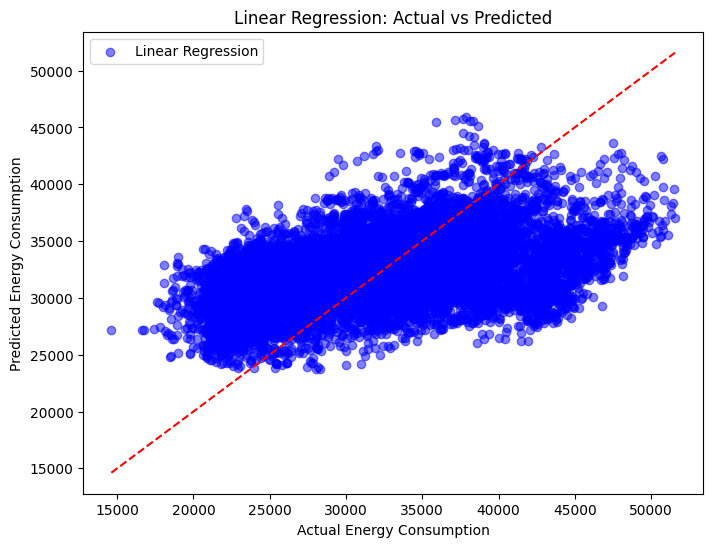

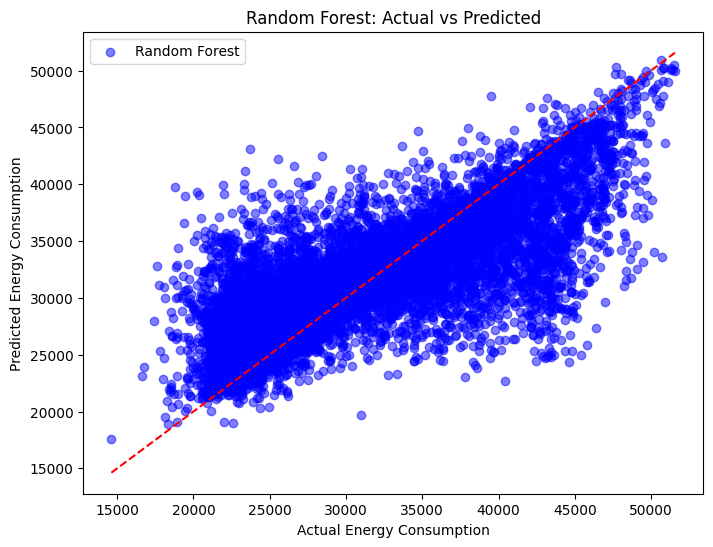

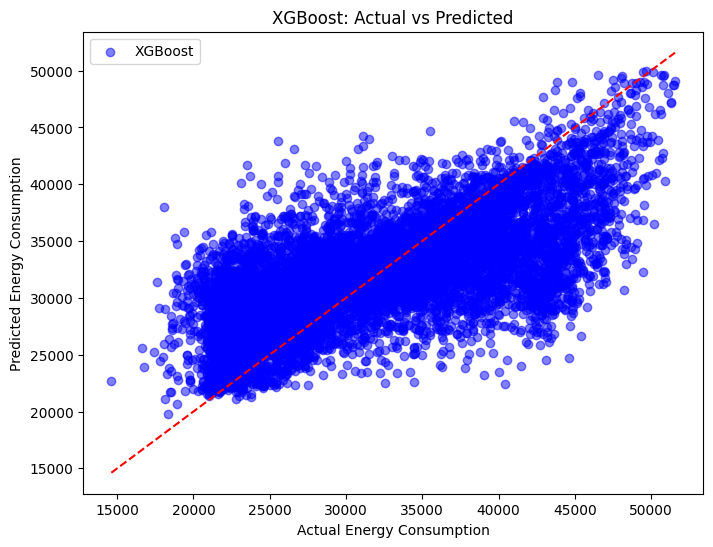

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot actual vs. predicted values
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    y_test = np.array(y_test).flatten()  # Convert to 1D array
    y_pred = np.array(y_pred).flatten()  # Convert to 1D array

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=model_name, color="blue")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Ideal line
    plt.xlabel("Actual Energy Consumption")
    plt.ylabel("Predicted Energy Consumption")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.legend()
    plt.show()

# Ensure models dictionary is defined before using it
if 'models' in locals():
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        plot_actual_vs_predicted(y_test, y_pred, name)
else:
    print("Error: 'models' dictionary is not defined.")


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Dictionary to store metrics
model_metrics = {}

# Evaluate each model
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Calculate error metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_metrics[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R² Score": r2}

# Print results
for model_name, metrics in model_metrics.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



Model: Linear Regression
MSE: 39842406.2183
RMSE: 6312.0841
MAE: 5185.7357
R² Score: 0.2110

Model: Random Forest
MSE: 21488349.5761
RMSE: 4635.5528
MAE: 3211.1885
R² Score: 0.5744

Model: XGBoost
MSE: 27557640.6802
RMSE: 5249.5372
MAE: 3956.4088
R² Score: 0.4542


(B)

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
data = pd.read_csv("/kaggle/input/energy-ml/household_power_consumption.txt")
data

,Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
0,16/12/2006;17:24:00;4.216;0.418;234.840;18.400...
1,16/12/2006;17:25:00;5.360;0.436;233.630;23.000...
2,16/12/2006;17:26:00;5.374;0.498;233.290;23.000...
3,16/12/2006;17:27:00;5.388;0.502;233.740;23.000...
4,16/12/2006;17:28:00;3.666;0.528;235.680;15.800...
...,...
2075254,26/11/2010;20:58:00;0.946;0.000;240.430;4.000;...
2075255,26/11/2010;20:59:00;0.944;0.000;240.000;4.000;...
2075256,26/11/2010;21:00:00;0.938;0.000;239.820;3.800;...
2075257,26/11/2010;21:01:00;0.934;0.000;239.700;3.800;...


In [40]:
import pandas as pd

# Load the dataset correctly
data = pd.read_csv("/kaggle/input/energy-ml/household_power_consumption.txt", sep=";", low_memory=False)

# Check column names
print(data.columns)  # Verify correct column names

# Convert "?" to NaN and drop missing values
data.replace("?", float("nan"), inplace=True)
data.dropna(inplace=True)

# Convert relevant columns to float
cols_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data[cols_to_convert] = data[cols_to_convert].astype(float)

# Convert 'Date' and 'Time' into a datetime column
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop original Date and Time columns
data.drop(columns=['Date', 'Time'], inplace=True)

# Display cleaned data
print(data.head())


Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')
   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            DateTime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 1

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

# Load and preprocess the dataset
data = pd.read_csv("/kaggle/input/energy-ml/household_power_consumption.txt", sep=";", low_memory=False)

# Handle missing values
data.replace("?", np.nan, inplace=True)
data.dropna(inplace=True)

# Convert necessary columns to float
cols_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data[cols_to_convert] = data[cols_to_convert].astype(float)

# Create a datetime column
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop Date and Time columns
data.drop(columns=['Date', 'Time'], inplace=True)

# Normalize the features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[cols_to_convert])

In [42]:
# Train-test split (use only normal data for training)
train_size = int(0.8 * len(data_scaled))
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]


In [43]:
# Autoencoder model
input_dim = train_data.shape[1]

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(input_dim, activation="sigmoid")
])

autoencoder.compile(optimizer="adam", loss="mse")


In [44]:
# Train the model
history = autoencoder.fit(train_data, train_data, 
                          epochs=10, batch_size=32, 
                          validation_data=(test_data, test_data), 
                          verbose=1)


Epoch 1/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - loss: 0.0032 - val_loss: 4.1099e-05
Epoch 2/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - loss: 4.4347e-05 - val_loss: 3.8653e-05
Epoch 3/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - loss: 3.7162e-05 - val_loss: 3.1781e-05
Epoch 4/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - loss: 3.4913e-05 - val_loss: 3.2402e-05
Epoch 5/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - loss: 3.3299e-05 - val_loss: 2.3757e-05
Epoch 6/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - loss: 3.1219e-05 - val_loss: 2.8195e-05
Epoch 7/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - loss: 3.0026e-05 - val_loss: 2.3801e-05
Epoch 8/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - loss: 3.0021e-05 - val_loss: 2.4594e-05
Epoch 9/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - loss: 2.9345e-05 - val_loss: 2.4450e-05
Epoch 10/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - loss: 2.8595e-05 - val_loss: 2.7447e-05


In [45]:
# Compute reconstruction error
train_reconstructions = autoencoder.predict(train_data)
test_reconstructions = autoencoder.predict(test_data)

51232/51232 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [46]:

train_loss = np.mean(np.square(train_data - train_reconstructions), axis=1)
test_loss = np.mean(np.square(test_data - test_reconstructions), axis=1)

In [47]:
threshold = np.mean(train_loss) + 3 * np.std(train_loss)

# Detect anomalies
anomalies = test_loss > threshold

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


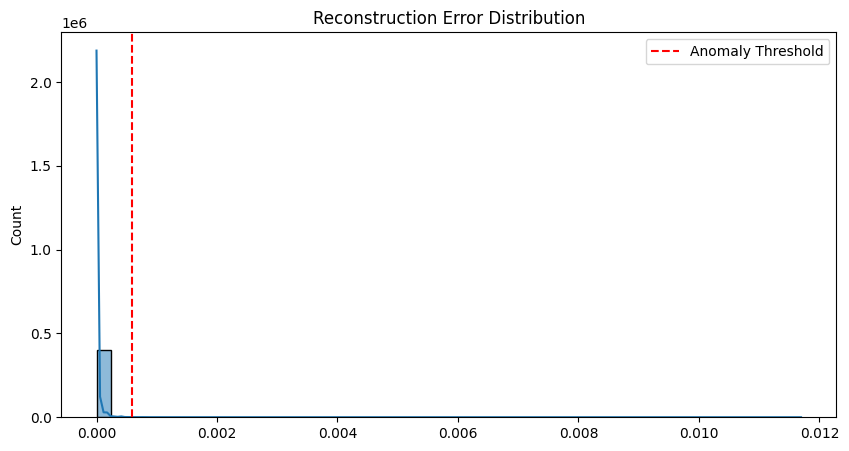

In [48]:
# Plot reconstruction error
plt.figure(figsize=(10, 5))
sns.histplot(test_loss, bins=50, kde=True)
plt.axvline(threshold, color="r", linestyle="dashed", label="Anomaly Threshold")
plt.title("Reconstruction Error Distribution")
plt.legend()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


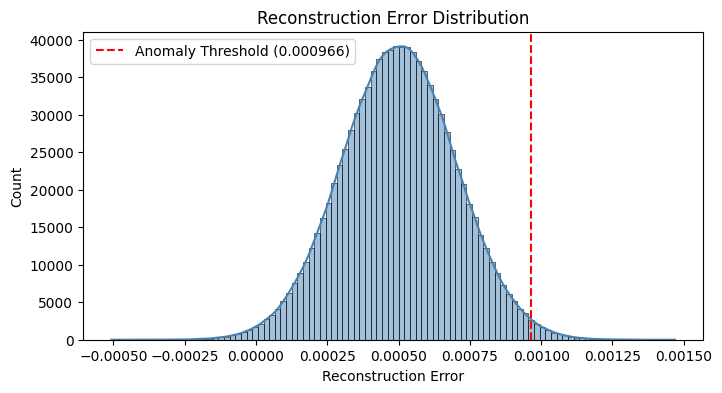

Anomaly Threshold (99th percentile): 0.000966


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample reconstruction errors (replace with actual model errors)
reconstruction_errors = np.random.normal(0.0005, 0.0002, 1000000)  # Simulated error values

# Set anomaly threshold at the 99th percentile
threshold = np.percentile(reconstruction_errors, 99)

# Plot the distribution of reconstruction errors
plt.figure(figsize=(8, 4))
sns.histplot(reconstruction_errors, bins=100, kde=True, color='steelblue')
plt.axvline(threshold, color='red', linestyle='dashed', label=f"Anomaly Threshold ({threshold:.6f})")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.show()

print(f"Anomaly Threshold (99th percentile): {threshold:.6f}")


In [50]:
threshold = np.percentile(reconstruction_errors, 99)
print(f"Anomaly Threshold (99th percentile): {threshold:.10f}")  # Show more precision


Anomaly Threshold (99th percentile): 0.0009660449


In [51]:
threshold = np.percentile(reconstruction_errors, 99)
print(f"Anomaly Threshold (99th percentile): {threshold:.10f}")  # More precision


Anomaly Threshold (99th percentile): 0.0009660449


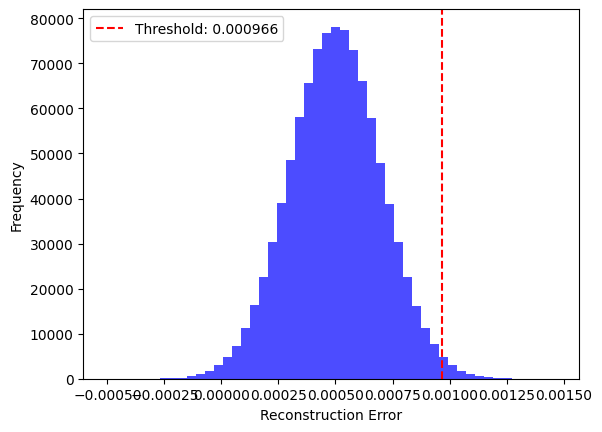

In [52]:
import matplotlib.pyplot as plt

plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue')
plt.axvline(threshold, color='red', linestyle='dashed', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [53]:
import joblib

# Save the trained model
joblib.dump(model, "/kaggle/working/trained_model.pkl")


['/kaggle/working/trained_model.pkl']

In [54]:
from IPython.display import FileLink

FileLink(r"/kaggle/working/trained_model.pkl")



/kaggle/working/trained_model.pkl